# ABCNN Visualizations

We can better understand what features the ABCNN model is learning by looking at its attention distributions.

The attention distributions for the ABCNN-1 blocks can help us to understand word and phrasal associations between sequences that the model is finding.

First, we import the necessary modules for the visualizations.

In [51]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from model.attention.utils import manhattan
from model.attention.utils import euclidean
from model.attention.utils import cosine
from model.attention.utils import compute_attention_matrix
from model.attention.abcnn1 import ABCNN1Attention
from model.attention.abcnn2 import ABCNN2Attention
from model.blocks.abcnn1 import ABCNN1Block
from model.blocks.abcnn2 import ABCNN2Block
from model.blocks.abcnn3 import ABCNN3Block
from model.convolution.conv import Convolution
from model.model import Model
from model.pooling.allap import AllAP
from model.pooling.widthap import WidthAP
from process import process_examples
from setup import read_config
from setup import setup_word2vec_model
from setup import setup_datasets
from setup import setup_embedding_matrix
from setup import setup_block
from setup import setup_model
from setup import weights_init
from setup import text_to_word_list
from utils import load_checkpoint

In [8]:
# Paths to necessary files
CONFIG_FILE = "config.json"
CHECKPOINT_FILE = "checkpoints/gpu1/best_checkpoint"
EMBEDDINGS_FILE = "embeddings/wiki.en.bin"

# Move operations to GPU if one is available
USE_CUDA = torch.cuda.is_available() 

In order to generate the heat maps faithfully, we'll need to load the pre-trained word2vec model (so we can access its vocabulary) and the set of stop words we used (so we can clean the input sequences).

In [9]:
# word2vec = KeyedVectors.load_word2vec_format(EMBEDDINGS_FILE, binary="True")
stops = set(stopwords.words("english"))

For this Notebook, we'll use a pre-trained ABCNN-3 models. We will also need to load in the datasets.

In [10]:
# Get dataset and model configurations
config = read_config(CONFIG_FILE)
max_length = config["model"]["max_length"]

In [11]:
# Get pre-trained word embeddings
# (Get a cup of coffee, this'll take about 10 minutes)
word_vectors = setup_word2vec_model(config)

Loading FastText word embeddings...


In [12]:
# Load datasets
datasets, word2index = setup_datasets(word_vectors, config)

Setting up datasets...


100%|██████████| 41238/41238 [00:09<00:00, 4289.94it/s]


In [13]:
# Create embedding matrix
embeddings = setup_embedding_matrix(word2index, word_vectors, config)

Creating embedding matrix...


100%|██████████| 86005/86005 [00:02<00:00, 34365.22it/s]


In [14]:
# Create the model
model = setup_model(embeddings, config)

Creating the ABCNN model...


In [16]:
# Overwrite model weights with pre-trained weights
state = load_checkpoint(CHECKPOINT_FILE)
model_dict, optim_dict, _, _ = state
model.load_state_dict(model_dict)

In [17]:
# See how to access the weights
for name, param in model.named_parameters():
    print(name, type(param.data), param.size())

embeddings.weight <class 'torch.Tensor'> torch.Size([86006, 300])
blocks.0.attn1.W1 <class 'torch.Tensor'> torch.Size([15, 300])
blocks.0.conv.conv.weight <class 'torch.Tensor'> torch.Size([50, 2, 3, 300])
blocks.0.conv.conv.bias <class 'torch.Tensor'> torch.Size([50])
blocks.1.attn1.W1 <class 'torch.Tensor'> torch.Size([15, 50])
blocks.1.conv.conv.weight <class 'torch.Tensor'> torch.Size([50, 2, 3, 50])
blocks.1.conv.conv.bias <class 'torch.Tensor'> torch.Size([50])
fc.weight <class 'torch.Tensor'> torch.Size([2, 800])
fc.bias <class 'torch.Tensor'> torch.Size([2])


# Quora Dataset

Now that we have the pre-trained model loaded and the datasets, the first thing we can do is inspect the attention matrices themselves for a few examples.

In [18]:
examples = [
    ["If someone tried to kidnap me what should I do?", "What can I do if someone tried to kidnap me?", 1],
    ["How do you write a better college essay?", "How do I write the best college application essay?", 1],
    ["What are the best-kept secrets of models?", "What are the best-kept secrets of great database models?", 0]
]

In [19]:
def text_to_index_tensor(s, max_length=20):
    """ Converts a string to a tensor of indices into the embedding matrix. """
    
    # Parse the text into words
    words = text_to_word_list(s)
    
    # Remove stop words
    if word_vectors is not None:
        words = list(filter(lambda s: s not in stops or s in word_vectors.vocab), words)
    else:
        words = list(filter(lambda s: s not in stops), words)
    
    # Convert words to indices
    # Use -1 as placeholder to indicate an OOV word
    indexes = []
    for word in words:
        try:
            indexes.append(word2index[word])
        except KeyError:
            indexes.append(-1)
            
    # Add padding
    indexes = indexes + [0 for _ in range(max_length - len(indexes))]

    # Convert to tensor
    indexes = torch.LongTensor(indexes)
    return indexes

In [20]:
def text_to_tensors(examples, max_length=20):
    """ Converts a list of examples (question1, question2, label) into torch Tensors. """
    # Split examples on columns
    q1 = [text_to_index_tensor(x[0], max_length=max_length) for x in examples]
    q2 = [text_to_index_tensor(x[1], max_length=max_length) for x in examples]
    label = [x[2] for x in examples]
    
    # Convert indices to feature maps
    q1_features = []
    for question in q1:
        for idx in question:
            try:
                lookup_tensor = torch.LongTensor([idx])
                feature = embeddings(lookup_tensor)
                q1_features.append(feature)
            except RuntimeError:
                if isinstance(word_vector, FastTextKeyedVectors):
                    feature = word_vector[]
    indexes = [
        (text_to_index_tensor(x[0], max_length=max_length), 
         text_to_index_tensor(x[1], max_length=max_length), 
         x[2]) for x in examples
    ]
    indexes = [torch.stack([x[0], x[1]], dim=0) for x in indexes]
    batch = torch.stack(indexes, dim=0)
    return batch

In [21]:
batch = text_to_tensors(examples, max_length=15)
batch = batch.cuda() if USE_CUDA else batch

## The attention distribution

Let's get the attention distribution for the first block. We'll use the manhattan metric to compute the match-scores.

In [22]:
# Load the embeddings
embeddings = torch.nn.Embedding.from_pretrained(model.state_dict().get("embeddings.weight"))

# Get the input feature maps
x1_0 = embeddings(batch[:, 0, :]).unsqueeze(1)
x2_0 = embeddings(batch[:, 1, :]).unsqueeze(1)

# Get the initial attention distribution
A_0 = compute_attention_matrix(x1_0, x2_0, manhattan)
print(A_0.shape)
A_0 = A_0.squeeze().cpu().numpy()

torch.Size([3, 1, 15, 15])


In [23]:
def generate_tick_labels(q1, q2, max_length=20):
    """ Creates labels for each tick on the heatmap. 
    
        Args:
            q1, q2: strings
                The text in the question pair.
            max_length: int
                The maximum length for any sequence.
                
        Returns:
            xticks, yticks: lists of strings
                The tokenized sequences. Padding tokens are appended
                if the sequences are contain fewer than max_length tokens.
    """
    # Sanity checks
    assert(isinstance(q1, str) and isinstance(q2, str) and isinstance(max_length, int))
    
    # Convert text to list of words, just as is done by the model
    words1 = text_to_word_list(q1)
    words2 = text_to_word_list(q2)   

    # Remove stop words that are not in the word2vec vocabulary
    words1 = list(filter(lambda s: s not in stops or s in word_vectors.vocab, words1))
    words2 = list(filter(lambda s: s not in stops or s in word_vectors.vocab, words2))
    
    # Make the labels
    yticks = list(words1)
    yticks = yticks + ["<unk>" for _ in range(max_length - len(yticks))]
    xticks = list(words2)
    xticks = xticks + ["<unk>" for _ in range(max_length - len(xticks))]
    
    return xticks, yticks

In [24]:
def generate_heat_map(A, q1, q2, max_length=20):
    """ Generates a heat map for the attention matrix. 
    
        Args:
            A: np.ndarray of shape (max_length, max_length)
                The attention matrix
            q1, q2: strings
                The text in the question pair
        
        Returns:
            None
    """
    # Sanity checks
    assert(len(A.shape) == 2 and A.shape[0] == A.shape[1])
    assert(isinstance(q1, str) and isinstance(q2, str))
    
    # Make plot bigger so its easier to read
    plt.rcParams['figure.figsize'] = 10, 10

    # Make custom x and y ticks with labels for this example
    max_length = A.shape[0]
    xticks, yticks = generate_tick_labels(q1, q2, max_length=max_length)

    # Make x ticks and labels appear on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

    # Plot the attention distribution
    plt.imshow(A, cmap='rainbow', interpolation='nearest')
    plt.xticks(range(max_length), xticks, rotation=90)
    plt.yticks(range(max_length), yticks)
    plt.colorbar()
    plt.show()

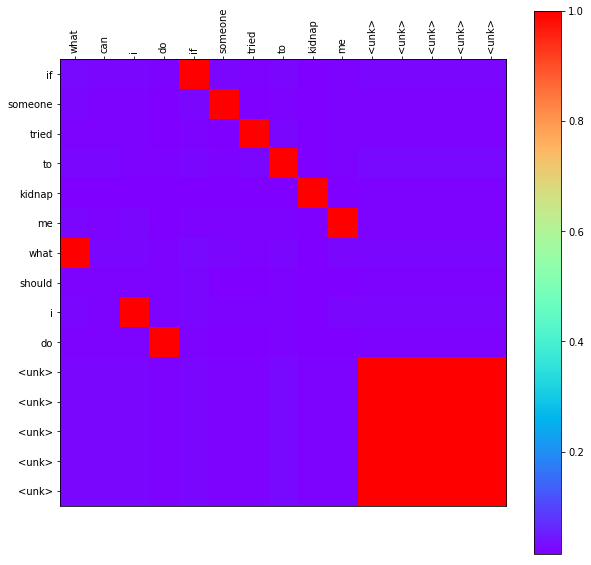

In [25]:
generate_heat_map(A_0[0], examples[0][0], examples[0][1], max_length=max_length)

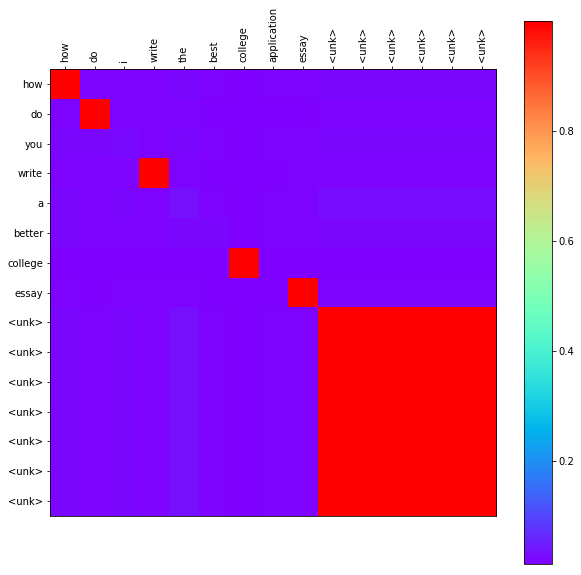

In [26]:
generate_heat_map(A_0[1], examples[1][0], examples[1][1], max_length=max_length)

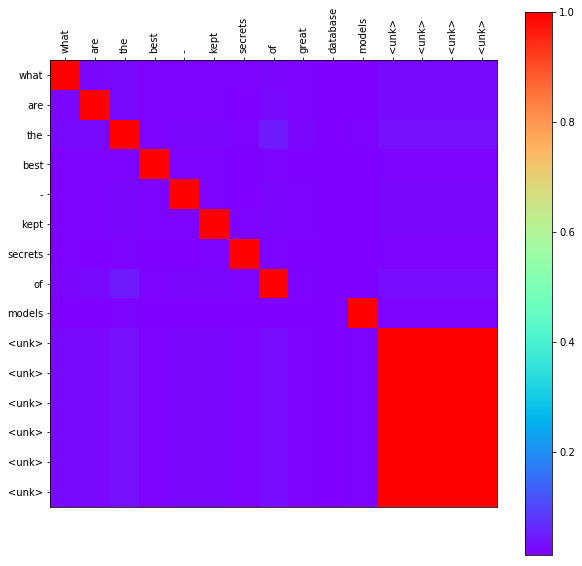

In [27]:
generate_heat_map(A_0[2], examples[2][0], examples[2][1], max_length=max_length)

Now let's try seeing what the attention distributions look like after the input goes through the first ABCNN-3 Block. First we'll need to replicate the architecture of the first Block.

In [28]:
# We'll need these to make the blocks
blocks_config = config["model"]["blocks"]

In [29]:
# Create the block
block_1_config = blocks_config[0]
block_1, output_size_1 = setup_block(max_length, block_1_config)
block_1 = block_1.eval() # Turn off dropout
block_1 = block_1.cuda() if USE_CUDA else block_1

# Overwrite the weights
block_1_dict = block_1.state_dict()
block_1_pretrained_dict = {}
for k, v in model_dict.items():
    if "blocks.0." in k:
        key = k.replace("blocks.0.", "")
        block_1_pretrained_dict[key] = v
block_1.load_state_dict(block_1_pretrained_dict)

print(x1_0.shape, x2_0.shape)

# Process the inputs
x1_1, x2_1, a1_1, a2_1 = block_1(x1_0, x2_0)

# Create the attention matrix
A_1 = compute_attention_matrix(x1_1, x2_1, euclidean)
A_1 = A_1.squeeze().detach().cpu().numpy()

torch.Size([3, 1, 15, 300]) torch.Size([3, 1, 15, 300])


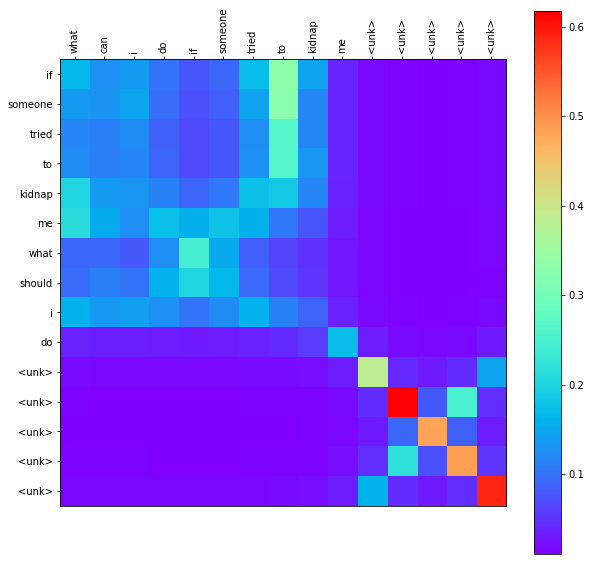

In [30]:
generate_heat_map(A_1[0], examples[0][0], examples[0][1], max_length=max_length)

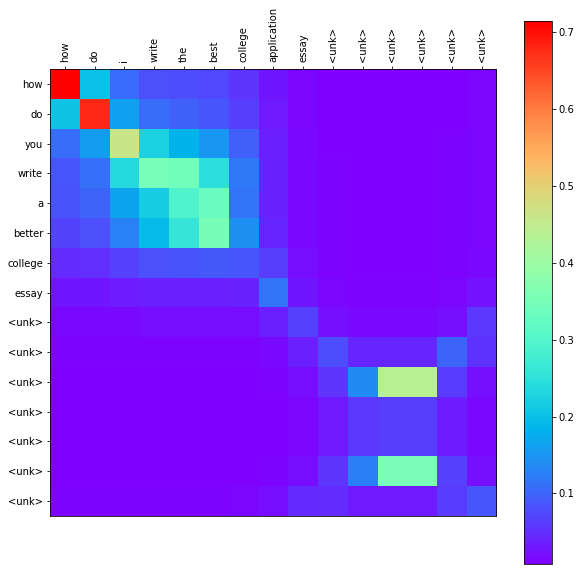

In [31]:
generate_heat_map(A_1[1], examples[1][0], examples[1][1], max_length=max_length)

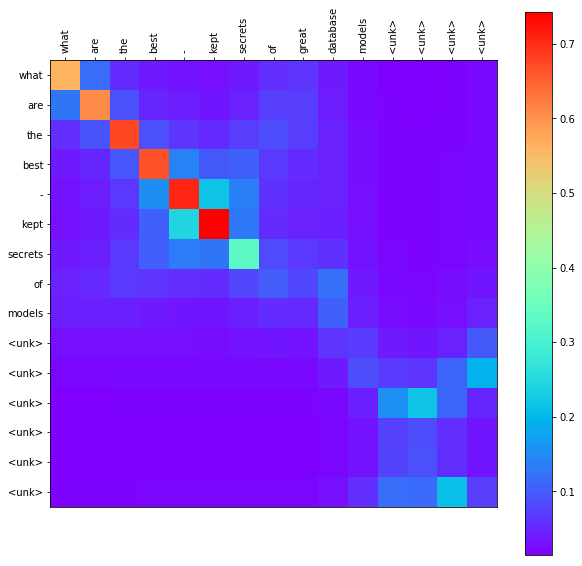

In [32]:
generate_heat_map(A_1[2], examples[2][0], examples[2][1], max_length=max_length)

And now let's see what the attention distribution looks like after the input passes through the second Block.

In [33]:
# Create the block
block_2_config = blocks_config[1]
block_2, output_size_2 = setup_block(max_length, block_2_config)
block_2 = block_2.eval() # turn off dropout
block_2 = block_2.cuda() if USE_CUDA else block_2

# Overwrite the weights
block_2_dict = block_2.state_dict()
block_2_pretrained_dict = {}
for k, v in model_dict.items():
    if "blocks.1." in k:
        key = k.replace("blocks.1.", "")
        block_2_pretrained_dict[key] = v
block_2.load_state_dict(block_2_pretrained_dict)

# Process the inputs
x1_2, x2_2, a1_2, a2_2 = block_2(x1_1, x2_1)

# Create the attention matrix
A_2 = compute_attention_matrix(x1_2, x2_2, euclidean)
A_2 = A_2.squeeze().detach().cpu().numpy()

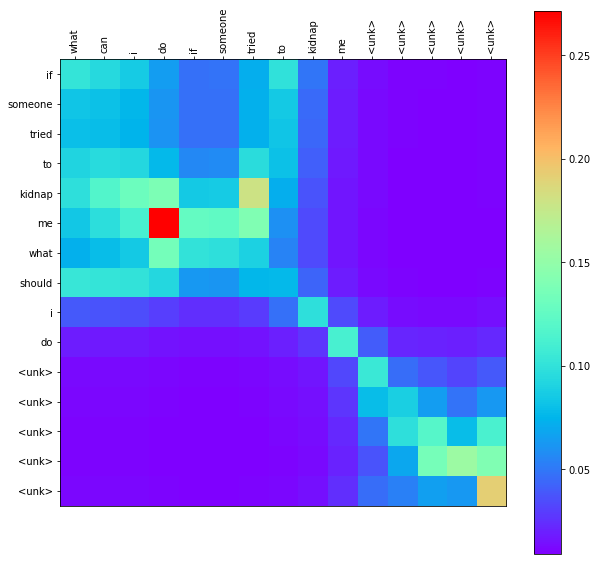

In [34]:
generate_heat_map(A_2[0], examples[0][0], examples[0][1], max_length=max_length)

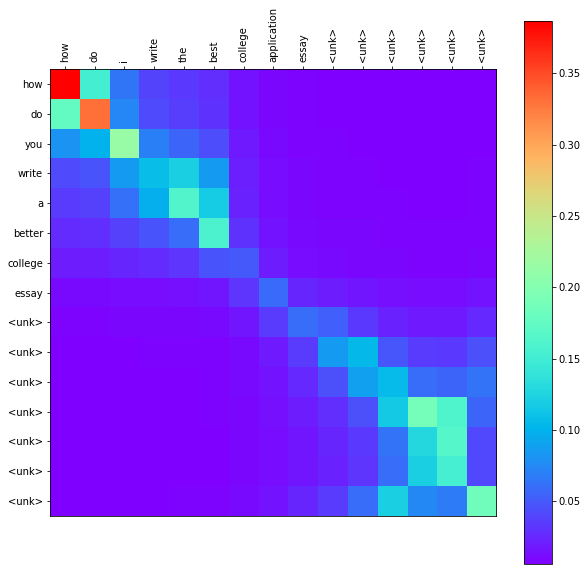

In [35]:
generate_heat_map(A_2[1], examples[1][0], examples[1][1], max_length=max_length)

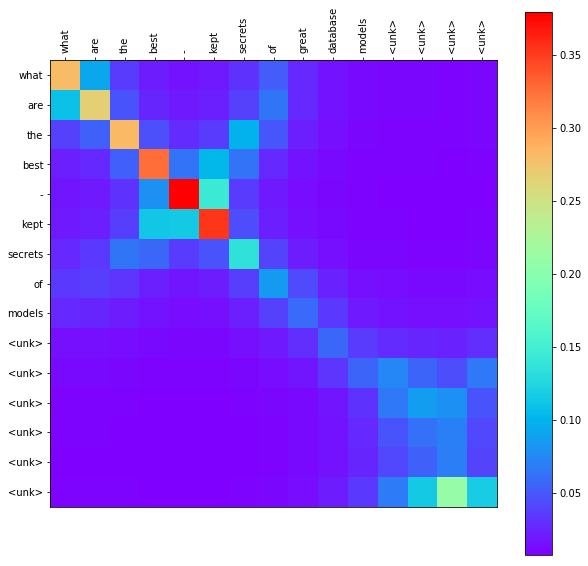

In [36]:
generate_heat_map(A_2[2], examples[2][0], examples[2][1], max_length=max_length)

# Hulo Dataset

Here are a few examples from the Hulo dataset:

In [37]:
hulo_examples = [
    ["how do I find a printer?", "The printer is not working. Looks to be offline.", 1],
    ["How to connect to printer?", "I can't add the printer", 1],
    ["How do I fix the keyboard of my mac", "VPN connection fail", 0],
    ["My VPN is broken", "Can't log in with VPN", 1]
]

In [38]:
hulo_batch = text_to_tensors(hulo_examples, max_length=15)
hulo_batch = hulo_batch.cuda() if USE_CUDA else hulo_batch
hulo_batch.shape

torch.Size([4, 2, 15])

In [39]:
# Load the embeddings
embeddings = torch.nn.Embedding.from_pretrained(model.state_dict().get("embeddings.weight"))

# Get the input feature maps
hulo_x1_0 = embeddings(hulo_batch[:, 0, :]).unsqueeze(1)
hulo_x2_0 = embeddings(hulo_batch[:, 1, :]).unsqueeze(1)

# Get the initial attention distribution
hulo_A_0 = compute_attention_matrix(hulo_x1_0, hulo_x2_0, euclidean)
hulo_A_0 = hulo_A_0.squeeze().cpu().numpy()

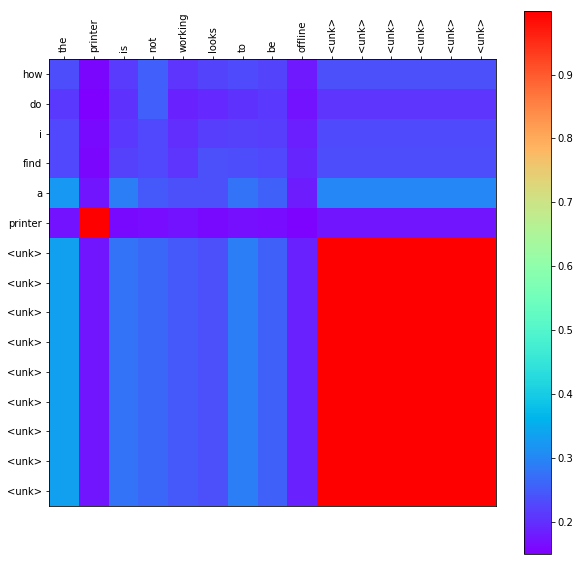

In [40]:
generate_heat_map(hulo_A_0[0], hulo_examples[0][0], hulo_examples[0][1], max_length=max_length)

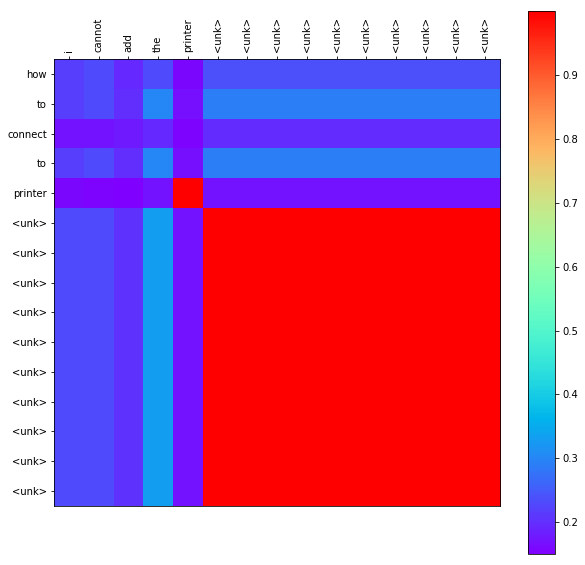

In [41]:
generate_heat_map(hulo_A_0[1], hulo_examples[1][0], hulo_examples[1][1], max_length=max_length)

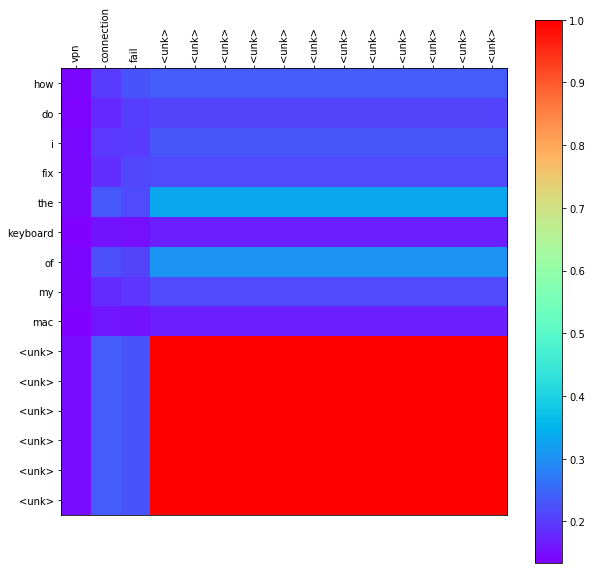

In [42]:
generate_heat_map(hulo_A_0[2], hulo_examples[2][0], hulo_examples[2][1], max_length=max_length)

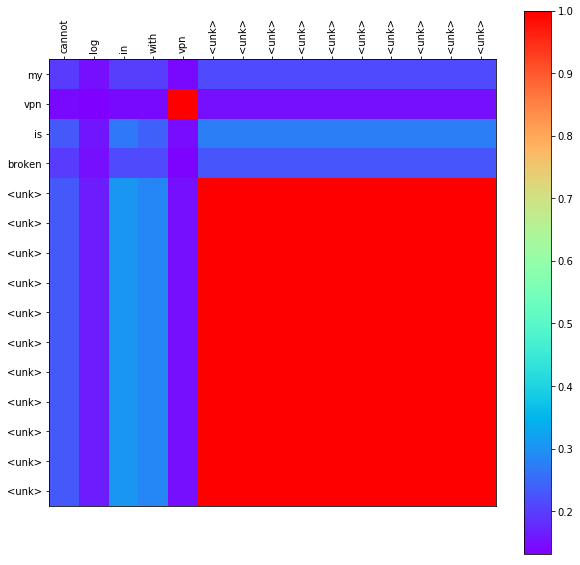

In [43]:
generate_heat_map(hulo_A_0[3], hulo_examples[3][0], hulo_examples[3][1], max_length=max_length)

From the looks of it, it seems like the words appearing in these Hulo queries did not appear in the Google News embeddings (or at the very least, were not trained sufficiently).

In [44]:
# Process the inputs
hulo_x1_1, hulo_x2_1, hulo_a1_1, hulo_a2_1 = block_1(hulo_x1_0, hulo_x2_0)

# Create the attention matrix
hulo_A_1 = compute_attention_matrix(hulo_x1_1, hulo_x2_1, euclidean)
hulo_A_1 = hulo_A_1.squeeze().detach().cpu().numpy()

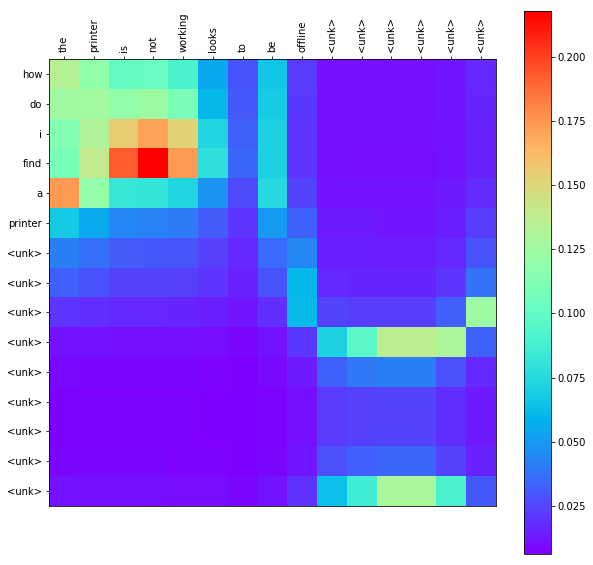

In [45]:
generate_heat_map(hulo_A_1[0], hulo_examples[0][0], hulo_examples[0][1], max_length=max_length)

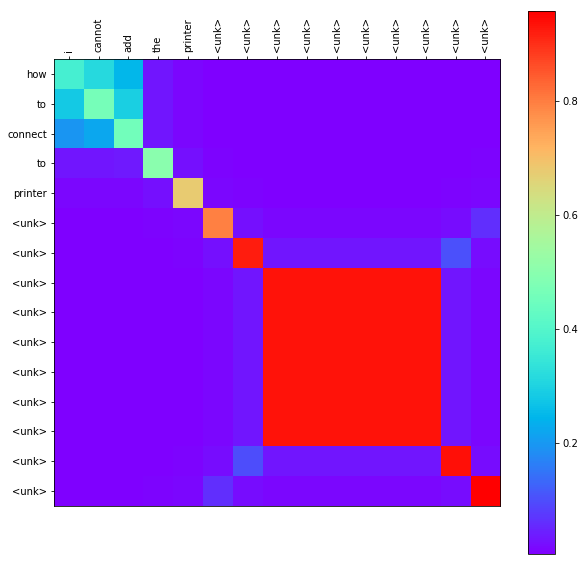

In [46]:
generate_heat_map(hulo_A_1[1], hulo_examples[1][0], hulo_examples[1][1], max_length=max_length)

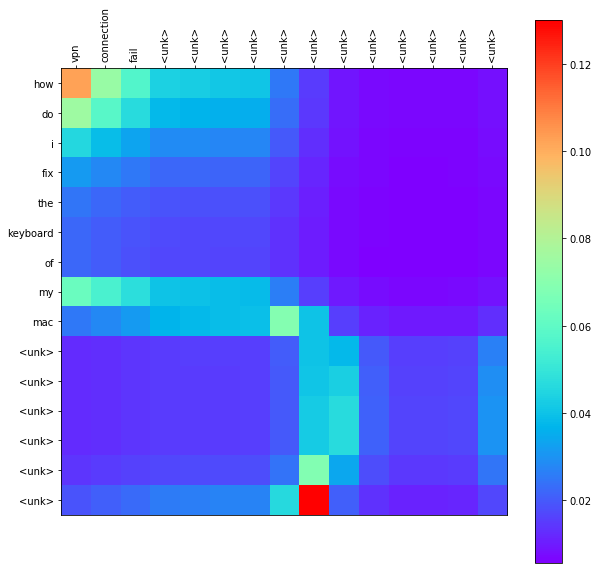

In [47]:
generate_heat_map(hulo_A_1[2], hulo_examples[2][0], hulo_examples[2][1], max_length=max_length)

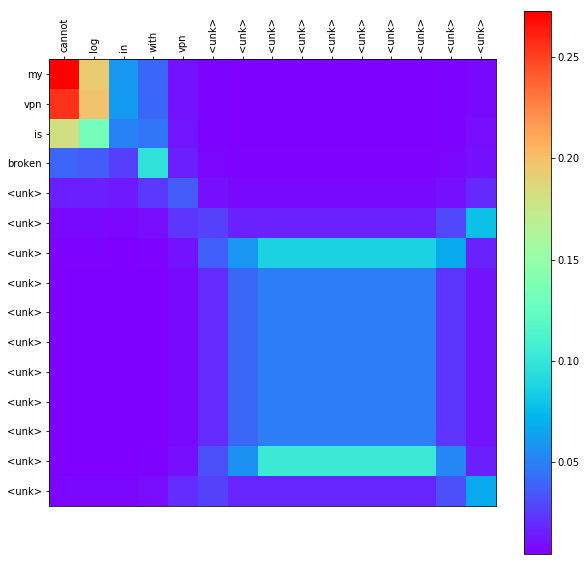

In [48]:
generate_heat_map(hulo_A_1[3], hulo_examples[3][0], hulo_examples[3][1], max_length=max_length)